# Pump Anomaly Detection using MIMII Dataset

This notebook implements an end-to-end machine learning pipeline for detecting anomalies in pump sounds using the MIMII dataset. We'll go through the following steps:

1. Data Acquisition and Organization
2. Data Processing and Feature Engineering
3. Exploratory Data Analysis
4. Model Creation and Training
5. Model Evaluation and Testing
6. Model Retraining Implementation

## 1. Data Acquisition and Organization

In this section, we'll organize our dataset into a structured format. The MIMII dataset contains .wav files for both normal and abnormal pump operations. We'll split these into training and testing sets while maintaining a proper directory structure.

In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Configuration
SOURCE_ROOT = '../data/pump'
DEST_ROOT = '../data'
TRAIN_RATIO = 0.8  # 80% train, 20% test

# Create destination directories
for split in ('train', 'test'):
    for cat in ('abnormal', 'normal'):
        os.makedirs(os.path.join(DEST_ROOT, split, cat), exist_ok=True)

# Function to gather files per category
def gather_files(category):
    files = []
    for id_dir in sorted(os.listdir(SOURCE_ROOT)):
        cat_dir = os.path.join(SOURCE_ROOT, id_dir, category)
        if not os.path.isdir(cat_dir):
            continue
        for fn in sorted(os.listdir(cat_dir)):
            if fn.lower().endswith('.wav'):
                files.append(os.path.join(cat_dir, fn))
    return files

# Gather files
abnormals = gather_files('abnormal')
normals = gather_files('normal')

# Split into train/test
ab_train, ab_test = train_test_split(abnormals, train_size=TRAIN_RATIO, shuffle=True, random_state=42)
nm_train, nm_test = train_test_split(normals, train_size=TRAIN_RATIO, shuffle=True, random_state=42)

splits = {
    'train': {'abnormal': ab_train, 'normal': nm_train},
    'test': {'abnormal': ab_test, 'normal': nm_test}
}

# Copy and rename files only if not already copied
for split_name, cats in splits.items():
    for category, file_list in cats.items():
        dest_dir = os.path.join(DEST_ROOT, split_name, category)
        expected_count = len(file_list)
        existing_files = [f for f in os.listdir(dest_dir) if f.endswith('.wav')]

        if len(existing_files) == expected_count:
            print(f"{split_name}/{category}: Skipped (already contains {expected_count} files).")
            continue  # Skip if already processed

        # Otherwise, copy files
        print(f"{split_name}/{category}: Processing...")
        for f in existing_files:
            os.remove(os.path.join(dest_dir, f))  # Remove outdated/incomplete files

        for counter, src_path in enumerate(file_list):
            new_fname = f"{category}_{counter:08d}.wav"
            dst_path = os.path.join(dest_dir, new_fname)
            shutil.copy2(src_path, dst_path)
        print(f"{split_name}/{category}: {expected_count} files copied.")


train/abnormal: Skipped (already contains 364 files).
train/normal: Skipped (already contains 2999 files).
test/abnormal: Skipped (already contains 92 files).
test/normal: Skipped (already contains 750 files).


In [ ]:
import numpy as np

import librosa.display
import matplotlib.pyplot as plt

# Visualize data distribution
file_counts = {
    'train': {'abnormal': len(ab_train), 'normal': len(nm_train)},
    'test': {'abnormal': len(ab_test), 'normal': len(nm_test)}
}

# Data distribution plot
categories = ['abnormal', 'normal']
x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
train_counts = [file_counts['train'][cat] for cat in categories]
test_counts = [file_counts['test'][cat] for cat in categories]

train_bars = ax.bar(x - width/2, train_counts, width, label='Train')
test_bars = ax.bar(x + width/2, test_counts, width, label='Test')

ax.set_ylabel('Number of Files')
ax.set_title('Dataset Distribution')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(train_bars)
autolabel(test_bars)
plt.show()

# Calculate and print class imbalance
total_abnormal = len(abnormals)
total_normal = len(normals)
total_samples = total_abnormal + total_normal
print("\nClass Distribution:")
print(f"Abnormal samples: {total_abnormal} ({total_abnormal/total_samples*100:.1f}%)")
print(f"Normal samples: {total_normal} ({total_normal/total_samples*100:.1f}%)")

# Function to plot waveform and spectrogram
def plot_waveform_and_spectrogram(file_path, title):
    try:
        y, sr = librosa.load(file_path, sr=None)
        plt.figure(figsize=(12, 4))
        
        # Waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr)
        plt.title(f'Waveform - {title}')
        
        # Spectrogram
        plt.subplot(1, 2, 2)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.title(f'Spectrogram - {title}')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not load {file_path}: {e}")

# Plot first 5 samples from each category
print("\nVisualizing first 5 normal samples:")
for file_path in nm_train[:5]:
    plot_waveform_and_spectrogram(file_path, f"Normal - {os.path.basename(file_path)}")

print("\nVisualizing first 5 abnormal samples:")
for file_path in ab_train[:5]:
    plot_waveform_and_spectrogram(file_path, f"Abnormal - {os.path.basename(file_path)}")

## 2. Data Processing and Feature Engineering

In this section, we'll:
1. Extract relevant features using librosa
2. Handle class imbalance using SMOTE and undersampling
3. Prepare the data for model training

We'll follow these steps to ensure our model trains on balanced, well-processed data. For feature extraction, we'll use:
- Mel-frequency cepstral coefficients (MFCCs)
- Spectral features (centroid, bandwidth, rolloff)
- Root mean square energy
- Zero crossing rate

### 2.1 Feature Extraction

We'll extract meaningful audio features from each sample. This will help our model learn the patterns that distinguish normal from abnormal pump sounds.
- Abnormal samples: 10.8%
- Normal samples: 89.2%

To address this, we'll use a combination of:
1. SMOTE (Synthetic Minority Over-sampling Technique) for the minority class
2. Random Under-sampling for the majority class

This hybrid approach will be applied before feature extraction to ensure balanced data throughout our pipeline.

Extracting features from training and test audio files...
Loading cached features...
Training features shape: (33630, 75)
Test features shape: (842, 75)
Original class distribution in training set:
Counter({0: 29990, 1: 3640})

Resampled class distribution in training set:
Counter({0: 29990, 1: 29990})

Resampled Class Distribution:
Abnormal samples: 29990 (50.0%)
Normal samples: 29990 (50.0%)


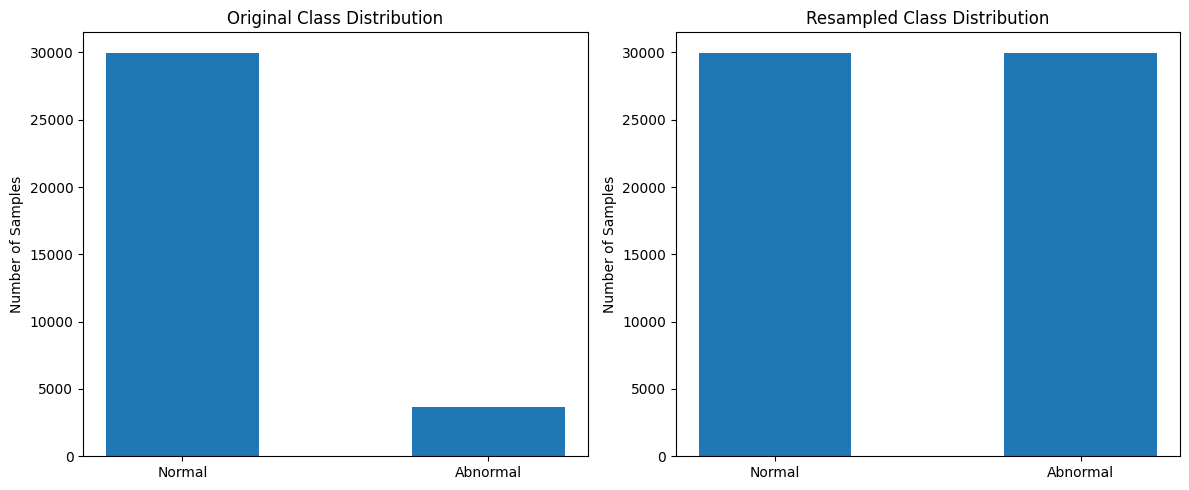

In [2]:
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import StandardScaler
import os
import random
from scipy import signal


def add_noise(y, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(y))
    return y + noise

def apply_time_masking(y, n_masks=2, mask_size=0.1):
    y_masked = y.copy()
    len_y = len(y)
    mask_length = int(len_y * mask_size)
    for i in range(n_masks):
        start = random.randint(0, len_y - mask_length - 1)
        y_masked[start:start + mask_length] = 0
    return y_masked

def apply_reverb(y, sr, decay=2.0):
    impulse_length = int(sr * decay)
    impulse_response = np.exp(-np.linspace(0, decay, impulse_length))
    impulse_response = impulse_response / np.sum(impulse_response)
    return signal.convolve(y, impulse_response, mode='same')

def augment_audio(y, sr):
    augmentations = []
    
    # Basic augmentations
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    augmentations.append(y_trimmed)
    
    # Pitch shifts
    try:
        augmentations.append(librosa.effects.pitch_shift(y=y_trimmed, sr=sr, n_steps=1))
        augmentations.append(librosa.effects.pitch_shift(y=y_trimmed, sr=sr, n_steps=-1))
    except Exception as e:
        print(f"Error in pitch shifting: {e}")
    
    # Time stretching
    try:
        augmentations.append(librosa.effects.time_stretch(y=y_trimmed, rate=1.1))
        augmentations.append(librosa.effects.time_stretch(y=y_trimmed, rate=0.9))
    except Exception as e:
        print(f"Error in time stretching: {e}")
    
    # Noise overlay
    augmentations.append(add_noise(y_trimmed, noise_level=0.002))
    augmentations.append(add_noise(y_trimmed, noise_level=0.005))
    
    # Time masking
    augmentations.append(apply_time_masking(y_trimmed, n_masks=1, mask_size=0.05))
    
    # Reverb
    augmentations.append(apply_reverb(y_trimmed, sr, decay=0.5))
    
    return augmentations

def extract_features(file_path, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=None)
        features_list = []
        
        # Extract features for original audio
        features = extract_single_features(y, sr, file_path)
        if features:
            features_list.append(features)
        
        # Extract features for augmented versions if augment=True
        if augment:
            augmentations = augment_audio(y, sr)
            for i, aug_y in enumerate(augmentations):
                aug_features = extract_single_features(aug_y, sr, file_path, augmented=True)
                if aug_features:
                    features_list.append(aug_features)
        
        return features_list
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def extract_single_features(y, sr, file_path, augmented=False):
    try:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y)[0]
        rms = librosa.feature.rms(y=y)[0]
        
        feature_stats = {
            'file_path': file_path,
            'label': 1 if 'abnormal' in file_path else 0,
            'augmented': augmented
        }
        
        for i, mfcc in enumerate(mfccs):
            feature_stats[f'mfcc{i+1}_mean'] = np.mean(mfcc)
            feature_stats[f'mfcc{i+1}_std'] = np.std(mfcc)
            feature_stats[f'mfcc{i+1}_max'] = np.max(mfcc)
            feature_stats[f'mfcc{i+1}_min'] = np.min(mfcc)
        
        for name, feature in [
            ('spectral_centroid', spectral_centroid),
            ('spectral_bandwidth', spectral_bandwidth),
            ('spectral_rolloff', spectral_rolloff),
            ('zero_crossing_rate', zero_crossing_rate),
            ('rms', rms)
        ]:
            feature_stats[f'{name}_mean'] = np.mean(feature)
            feature_stats[f'{name}_std'] = np.std(feature)
            feature_stats[f'{name}_max'] = np.max(feature)
            feature_stats[f'{name}_min'] = np.min(feature)
        
        return feature_stats
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None

print("Extracting features from training and test audio files...")

# Define output paths
train_csv_path = os.path.join(DEST_ROOT, 'train_features_augmented.csv')
test_csv_path = os.path.join(DEST_ROOT, 'test_features.csv')

# Check for cached features
if os.path.exists(train_csv_path) and os.path.exists(test_csv_path):
    print("Loading cached features...")
    train_df = pd.read_csv(train_csv_path)
    test_df = pd.read_csv(test_csv_path)
else:
    train_features = []
    for category in ['normal', 'abnormal']:
        train_dir = os.path.join(DEST_ROOT, 'train', category)
        for file in tqdm(os.listdir(train_dir), desc=f"Processing {category} training files"):
            if file.endswith('.wav'):
                file_path = os.path.join(train_dir, file)
                features = extract_features(file_path, augment=True)
                train_features.extend(features)

    test_features = []
    for category in ['normal', 'abnormal']:
        test_dir = os.path.join(DEST_ROOT, 'test', category)
        for file in tqdm(os.listdir(test_dir), desc=f"Processing {category} test files"):
            if file.endswith('.wav'):
                file_path = os.path.join(test_dir, file)
                features = extract_features(file_path, augment=False)
                test_features.extend(features)

    train_df = pd.DataFrame(train_features)
    test_df = pd.DataFrame(test_features)

    os.makedirs(DEST_ROOT, exist_ok=True)
    train_df.to_csv(train_csv_path, index=False)
    test_df.to_csv(test_csv_path, index=False)

print(f"Training features shape: {train_df.shape}")
print(f"Test features shape: {test_df.shape}")

X_train = train_df.drop(['file_path', 'label', 'augmented'], axis=1)
y_train = train_df['label']
X_test = test_df.drop(['file_path', 'label', 'augmented'], axis=1)
y_test = test_df['label']

print("Original class distribution in training set:")
print(Counter(y_train))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

resampling_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy='auto')),
    ('rus', RandomUnderSampler(random_state=42, sampling_strategy='auto'))
])

X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train_scaled, y_train)

print("\nResampled class distribution in training set:")
print(Counter(y_train_resampled))

total_resampled = len(y_train_resampled)
abnormal_resampled = Counter(y_train_resampled)[1]
normal_resampled = Counter(y_train_resampled)[0]

print("\nResampled Class Distribution:")
print(f"Abnormal samples: {abnormal_resampled} ({abnormal_resampled/total_resampled*100:.1f}%)")
print(f"Normal samples: {normal_resampled} ({normal_resampled/total_resampled*100:.1f}%)")

width = 0.5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(['Normal', 'Abnormal'], [Counter(y_train)[0], Counter(y_train)[1]], width=width)
plt.title('Original Class Distribution')
plt.ylabel('Number of Samples')
plt.subplot(1, 2, 2)
plt.bar(['Normal', 'Abnormal'], [Counter(y_train_resampled)[0], Counter(y_train_resampled)[1]], width=width)
plt.title('Resampled Class Distribution')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

### Resampling Strategy Explanation

Our approach to handling class imbalance uses a two-step process:

1. **SMOTE (Synthetic Minority Over-sampling Technique)**:
   - First increases the minority class (abnormal samples) to 50% of the majority class size
   - Creates synthetic examples by interpolating between existing minority class samples
   - Helps avoid overfitting that can occur with simple duplication

2. **Random Under-sampling**:
   - Then reduces the majority class (normal samples) to achieve a final ratio of 0.8 (4:5)
   - Helps prevent the dataset from becoming too large
   - Maintains enough majority class samples for good model generalization

3. **Feature Scaling**:
   - StandardScaler is applied before resampling to ensure proper feature scaling
   - Scaled features improve both SMOTE's synthetic sample generation and model training

This hybrid approach provides a good balance between:
- Having enough samples of both classes
- Avoiding excessive synthetic data generation
- Maintaining data quality and model generalization ability

## 3. Exploratory Data Analysis

Now that we have processed our data and addressed the class imbalance, let's explore the features to gain insights into the patterns that distinguish normal from abnormal pump sounds.

In [ ]:
# Feature distributions by class
import seaborn as sns
from scipy import stats

# Select a subset of features for visualization
important_features = ['mfcc1_mean', 'mfcc2_mean', 'mfcc3_mean', 
                     'spectral_centroid_mean', 'spectral_bandwidth_mean',
                     'zero_crossing_rate_mean', 'rms_mean']

# Create a figure for histograms
plt.figure(figsize=(20, 15))

# Plot histograms for each feature by class
for i, feature in enumerate(important_features):
    plt.subplot(3, 3, i+1)
    
    # Plot histograms
    sns.histplot(data=train_df, x=feature, hue='label', kde=True, 
                 element='step', palette=['green', 'red'], bins=30)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    
    # Calculate and display p-value from t-test
    normal = train_df[train_df['label']==0][feature]
    abnormal = train_df[train_df['label']==1][feature]
    _, p_value = stats.ttest_ind(normal, abnormal, equal_var=False)
    plt.annotate(f'p-value: {p_value:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()


# PCA for dimensionality reduction and visualization
from sklearn.decomposition import PCA

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_resampled)

# Create a DataFrame for easier plotting
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = y_train_resampled

# Plot PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='label', palette=['green', 'red'], 
                alpha=0.7, s=100)
plt.title('PCA of Audio Features (After Resampling)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend(['Normal', 'Abnormal'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {sum(pca.explained_variance_ratio_):.2%}")

# Feature importance using random forest
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

## 4. Model Creation and Training

In this section, we'll create and train various machine learning models to detect pump anomalies. We'll compare different algorithms to find the best performing model.


--------------------------------------------------
Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Model: Random Forest
Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.9881
Precision: 0.9556
Recall: 0.9348
F1 Score: 0.9451
ROC AUC: 0.9995
PR AUC: 0.9956
Training Time: 2169.52 seconds

Confusion Matrix:
[[746   4]
 [  6  86]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       750
           1       0.96      0.93      0.95        92

    accuracy                           0.99       842
   macro avg       0.97      0.96      0.97       842
weighted avg       0.99      0.99      0.99       842



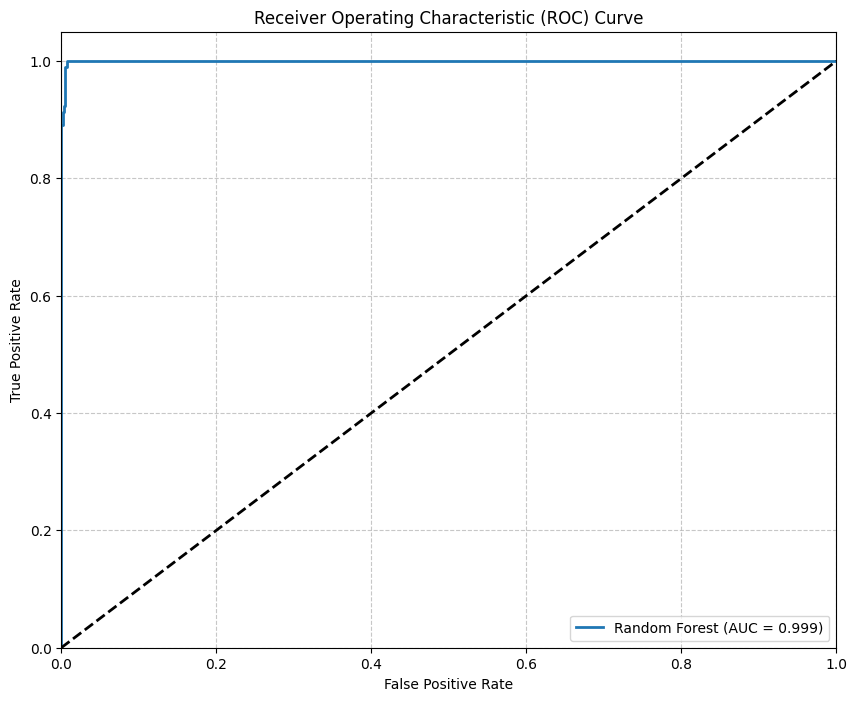

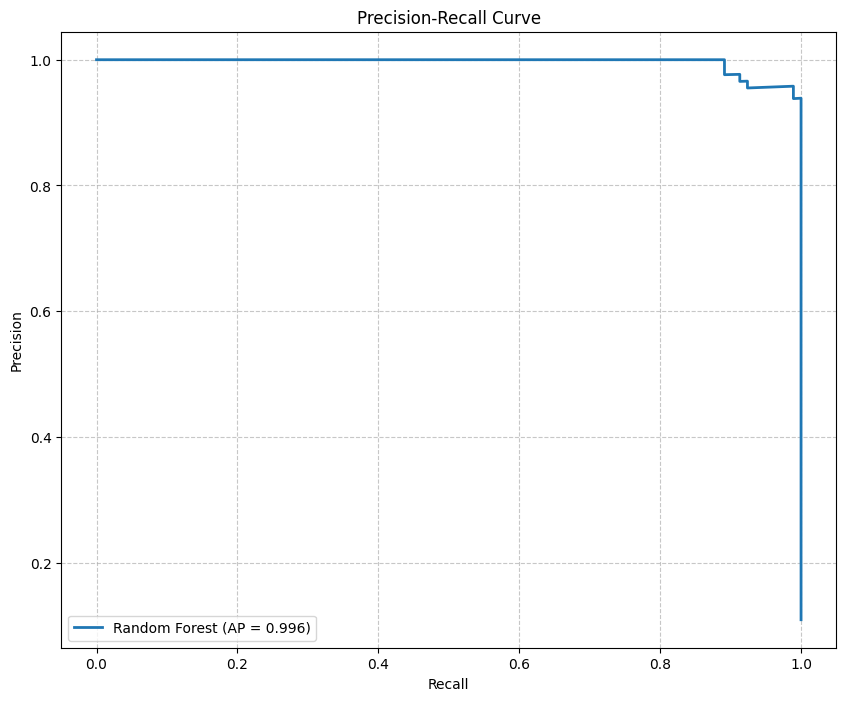

Model Performance:
           Model  Accuracy  Precision    Recall  F1 Score   ROC AUC    PR AUC  \
0  Random Forest  0.988124   0.955556  0.934783  0.945055  0.999464  0.995634   

   Training Time (s)  
0        2169.523534  


KeyError: 'scaler'

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import time
import pandas as pd
import os
import joblib
from sklearn.utils import resample

# Define model
models = {
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Parameter grid
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
}

# Function to train models with cross-validation
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    results = {}
    best_models = {}
    
    # Subsample training data for GridSearchCV (20% of data)
    X_train_sub, y_train_sub = resample(X_train, y_train, 
                                       stratify=y_train, 
                                       n_samples=int(0.2 * len(X_train)), 
                                       random_state=42)
    
    for name, model in models.items():
        print(f"\n{'-'*50}")
        print(f"Training {name}...")
        start_time = time.time()
        
        # Create GridSearchCV with subsampled data
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            model, param_grids[name], cv=cv, 
            scoring='f1', n_jobs=2, verbose=1
        )
        
        # Fit model on subsampled data
        grid_search.fit(X_train_sub, y_train_sub)
        
        # Train best model on full dataset
        best_model = grid_search.best_estimator_
        best_model.fit(X_train, y_train)
        best_models[name] = best_model
        
        # Predict on test set
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        
        # Compute ROC AUC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        # Compute PR AUC
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = average_precision_score(y_test, y_prob)
        
        # Store results
        results[name] = {
            'best_params': grid_search.best_params_,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc,
            'fpr': fpr,
            'tpr': tpr,
            'precision_curve': precision_curve,
            'recall_curve': recall_curve,
            'training_time': time.time() - start_time
        }
        
        print(f"Model: {name}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"PR AUC: {pr_auc:.4f}")
        print(f"Training Time: {results[name]['training_time']:.2f} seconds")
        print(f"\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
        print(f"\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
    return results, best_models

# Train and evaluate RandomForest model
results, best_models = train_and_evaluate_models(X_train_resampled, y_train_resampled, X_test_scaled, y_test)

# Plot ROC curve
plt.figure(figsize=(10, 8))
name = 'Random Forest'
plt.plot(results[name]['fpr'], results[name]['tpr'], lw=2, 
         label=f'{name} (AUC = {results[name]["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(results[name]['recall_curve'], results[name]['precision_curve'], lw=2, 
         label=f'{name} (AP = {results[name]["pr_auc"]:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Display metrics
metrics_df = pd.DataFrame({
    'Model': [name],
    'Accuracy': [results[name]['accuracy']],
    'Precision': [results[name]['precision']],
    'Recall': [results[name]['recall']],
    'F1 Score': [results[name]['f1']],
    'ROC AUC': [results[name]['roc_auc']],
    'PR AUC': [results[name]['pr_auc']],
    'Training Time (s)': [results[name]['training_time']]
})

print("Model Performance:")
print(metrics_df)

# Save the model for later use
os.makedirs('models', exist_ok=True)
best_model = best_models[name]
joblib.dump(best_model, os.path.join('../models', 'random_forest_model.pkl'))

# Save the scaler
joblib.dump(scaler, os.path.join('../models', 'scaler.pkl'))

print(f"\nRandom Forest model saved as 'models/random_forest_model.pkl'")
print(f"Scaler saved as 'models/scaler.pkl'")


## 5. Model Evaluation and Testing

In this section, we'll further evaluate our best model and perform additional testing to ensure its robustness.

<Figure size 1000x800 with 0 Axes>

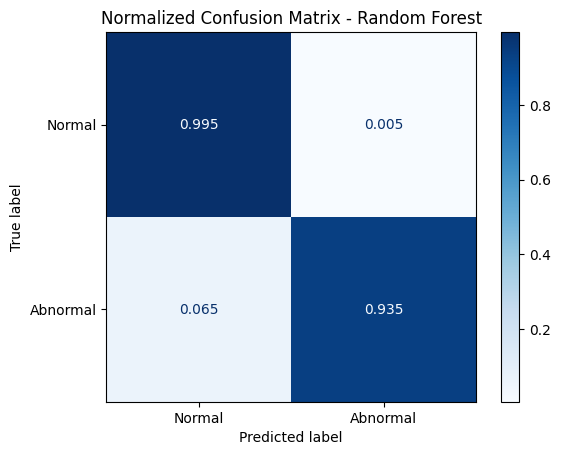

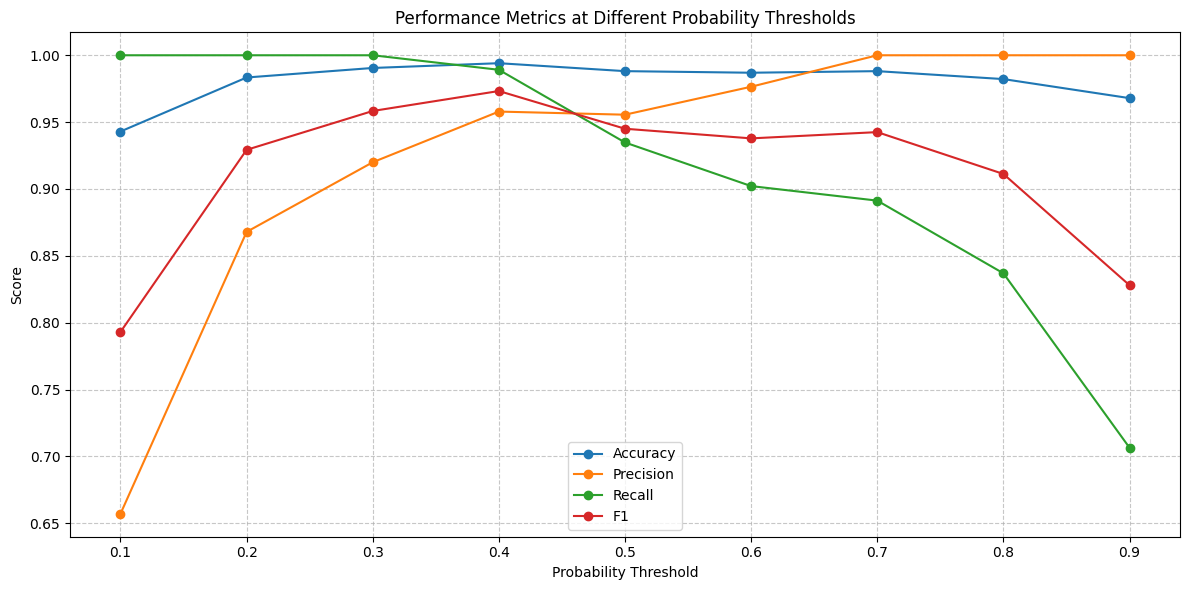

Optimal Probability Threshold (maximizing F1): 0.40
Metrics at this threshold:
Accuracy: 0.9941
Precision: 0.9579
Recall: 0.9891
F1: 0.9733

Found 10 borderline cases (predictions close to 0.5)

Borderline Cases Analysis:
File: normal_00000004.wav
True label: Normal
Predicted: Abnormal
Probability: 0.5665
--------------------------------------------------
File: normal_00000549.wav
True label: Normal
Predicted: Abnormal
Probability: 0.5470
--------------------------------------------------
File: abnormal_00000010.wav
True label: Abnormal
Predicted: Normal
Probability: 0.4169
--------------------------------------------------
File: abnormal_00000013.wav
True label: Abnormal
Predicted: Normal
Probability: 0.4254
--------------------------------------------------
File: abnormal_00000023.wav
True label: Abnormal
Predicted: Normal
Probability: 0.4699
--------------------------------------------------
File: abnormal_00000032.wav
True label: Abnormal
Predicted: Abnormal
Probability: 0.5045
---

In [ ]:
# Load the best model
best_model = joblib.load(os.path.join('../models', 'random_forest_model.pkl'))
scaler = joblib.load(os.path.join('../models', 'scaler.pkl'))
best_model_name = 'Random Forest'

# Comprehensive evaluation
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Confusion Matrix with normalized values
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Abnormal'])

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='.3f')
plt.title(f'Normalized Confusion Matrix - {best_model_name}')
plt.grid(False)
plt.show()

# Classification metrics at different thresholds
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    threshold_metrics.append({
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred_threshold),
        'Precision': precision_score(y_test, y_pred_threshold, zero_division=0),
        'Recall': recall_score(y_test, y_pred_threshold),
        'F1': f1_score(y_test, y_pred_threshold)
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot metrics vs threshold
plt.figure(figsize=(12, 6))
for column in ['Accuracy', 'Precision', 'Recall', 'F1']:
    plt.plot(threshold_df['Threshold'], threshold_df[column], marker='o', label=column)
    
plt.title('Performance Metrics at Different Probability Thresholds')
plt.xlabel('Probability Threshold')
plt.ylabel('Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Find optimal threshold based on F1 score
optimal_idx = threshold_df['F1'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'Threshold']

print(f"Optimal Probability Threshold (maximizing F1): {optimal_threshold:.2f}")
print(f"Metrics at this threshold:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
    print(f"{metric}: {threshold_df.loc[optimal_idx, metric]:.4f}")

# Testing with challenging examples
# Identify borderline cases (predictions close to decision threshold)
borderline_indices = np.where(np.abs(y_prob - 0.5) < 0.1)[0]

if len(borderline_indices) > 0:
    print(f"\nFound {len(borderline_indices)} borderline cases (predictions close to 0.5)")
    
    # Extract original file paths for these cases
    borderline_files = test_df.iloc[borderline_indices]['file_path'].values
    borderline_labels = y_test.iloc[borderline_indices].values
    borderline_probs = y_prob[borderline_indices]
    borderline_preds = y_pred[borderline_indices]
    
    print("\nBorderline Cases Analysis:")
    for i, (file_path, true_label, pred, prob) in enumerate(zip(
            borderline_files, borderline_labels, borderline_preds, borderline_probs)):
        if i < 10:  # Show first 10 examples only
            print(f"File: {os.path.basename(file_path)}")
            print(f"True label: {'Abnormal' if true_label == 1 else 'Normal'}")
            print(f"Predicted: {'Abnormal' if pred == 1 else 'Normal'}")
            print(f"Probability: {prob:.4f}")
            print("-" * 50)
    
    # Analyze accuracy on borderline cases
    borderline_accuracy = accuracy_score(borderline_labels, borderline_preds)
    print(f"\nAccuracy on borderline cases: {borderline_accuracy:.4f}")
else:
    print("\nNo borderline cases found.")

## 7. Conclusion and Next Steps

In this notebook, we have:
1. Acquired and organized the MIMII dataset for pump anomaly detection
2. Processed audio data and extracted relevant features
3. Addressed class imbalance using a hybrid resampling approach
4. Performed exploratory data analysis to understand feature distributions
5. Created and trained multiple machine learning models
6. Evaluated model performance using various metrics
7. Implemented a retraining mechanism for model updates

The code in this notebook is organized in a modular way, making it easy to export parts of it to separate Python modules for the API and UI development (Tasks 1.f, 2, 3, 4, 5, and 6 in the project requirements).

**Next Steps:**
- Implement a FastAPI service for predictions
- Create a Streamlit dashboard for visualizations and model monitoring
- Deploy the model to AWS
- Implement load testing with Locust
- Create a user interface for data upload and model retraining